# Overview of perturbations with associated quintuplicate SEM (kcal/mol)

In [1]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
from collections import defaultdict

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.warning')
from rdkit.Chem import Draw, rdFMCS

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor, rdmolfiles
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.image as mpimg

In [2]:
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])
quints_infos.sort_values(by="sem")

,set,pertname,pertsmarts,num_ha,sem
853,TrainingSet,mobley_2802855~mobley_1563176,[C*]Br~[C*]S,1,0.006843
852,TrainingSet,mobley_1563176~mobley_2802855,[C*]S~[C*]Br,1,0.006843
1819,TrainingSet,mobley_7708038~mobley_186894,[C*]Br~[C*]S,1,0.010947
1818,TrainingSet,mobley_186894~mobley_7708038,[C*]S~[C*]Br,1,0.010947
916,TrainingSet,mobley_1017962~mobley_7977115,[C*]O.[C*]OC~[CH*]O,3,0.013678
...,...,...,...,...,...
2670,TrainingSet,mobley_1571523~mobley_2763835,[C*]C.[C*]C~[O*]CC,3,25.098582
530,TrainingSet,mobley_1036761~mobley_4218209,~[C*]OC,2,33.708322
531,TrainingSet,mobley_4218209~mobley_1036761,[C*]OC~,2,33.708322
1093,TrainingSet,mobley_2859600~mobley_1036761,[C*]CC~[CH*]N,2,38.086474


In [3]:
#Draw the molecule
def get_image(mol,atomset=None):    
    hcolor = colors.to_rgb('red')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img


def generateImages(mol,row,core,width=350,height=200,
                      fillRings=False,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=None):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    # loop over R groups.
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        try:
            rquery = row[lbl]
        # we don't know the number of R-groups, so just quit this loop if we've reached the end.
        except KeyError:
        	continue

        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,"",dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()

    # save to file:
    d2d.WriteDrawingText("tmp_imgs/"+legend+".png")
        
    return png

In [11]:
def plot_perts(quints_infos, precision=7):
    
    ligs_path = "./quintup_ligands/sdffiles/"

    for idx, pertinfo in quints_infos.iterrows():
        pert = pertinfo["pertname"]
        
        # get the five freenrg values that make up the SEM.
        # do this first because if this fails this is a reversed pert and we don't want to plot it.
        perts_mbars = pd.read_csv("quintup_ligands/compiled_mbar_freenrgs.csv")
        try:
            mbar_vals = perts_mbars[perts_mbars["pert"] == pert][["freenrg_1", "freenrg_2", "freenrg_3", "freenrg_4", "freenrg_5"]].values[0]
        except IndexError:
            continue
            
        
        print(pert)
        
        ## get the paths to simulation folders on yoko
        with open("/home/jscheen/projects/HYDRA_LEARN/QUINTUP/COLLECTION/all_mbar_paths.txt", "r") as pathsfile:
            reader = csv.reader(pathsfile)
            for row in reader:
                if pert in row[0]:
                    print(row[0])
        
        ##
        


        ligA = Chem.SDMolSupplier(ligs_path+pert.split("~")[0]+".sdf")[0]
        ligB = Chem.SDMolSupplier(ligs_path+pert.split("~")[1]+".sdf")[0]

        mcs = rdFMCS.FindMCS([ligA, ligB], matchValences=False,
                                        ringMatchesRingOnly=True,
                                        completeRingsOnly=True,
                                        matchChiralTag=False)
        core = Chem.MolFromSmarts(mcs.smartsString)
        rdDepictor.Compute2DCoords(core)

        rdkit_mols = [ligA, ligB]
        # find subtructure matches with MCS per ligand, then tag matching atom indices in each ligand.
        ps = Chem.AdjustQueryParameters.NoAdjustments()
        ps.makeDummiesQueries=True
        qcore = Chem.AdjustQueryProperties(core,ps)
        #mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
        mms = [x for x in rdkit_mols if x.HasSubstructMatch(core)]
        for m in mms:
            for atom in m.GetAtoms():
                atom.SetIntProp("SourceAtomIdx",atom.GetIdx())

        # do an RDKit R-group decomposition.	
        groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

        # call the writer function with each molecule.
        ligand_names = [pert.split("~")[0], pert.split("~")[1]]
        #for i, m in enumerate(rdkit_mols):

        generateImages(rdkit_mols[0],groups[0],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[0],
                                width=400,height=400)
        generateImages(rdkit_mols[1],groups[1],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[1],
                                width=400,height=400)


        # now that this image is saved, load it into matplotlib for easier side-by-sde viewing.
        imgA = mpimg.imread("tmp_imgs/"+ligand_names[0]+".png")
        imgB = mpimg.imread("tmp_imgs/"+ligand_names[1]+".png")

        fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 3, 1, 1]})
        axes[0].imshow(imgA)
        axes[1].imshow(imgB)

        # get some more pert info and annotate it.
        axes[2].annotate("    SEM:", xy=(0, 0.7), size=25)
        axes[3].annotate(round(pertinfo["sem"], 7), xy=(0, 0.7), size=25)

        axes[2].annotate("SMARTS:", xy=(0, 0.3), size=20)
        axes[3].annotate(pertinfo["pertsmarts"], xy=(0, 0.3), size=15)
        
        # annotate the SEm constituents.
        
        for i, val in enumerate(mbar_vals):
            axes[3].annotate(round(float(val), precision), xy=(0, 0.6-(i*0.05)))
        axes[2].annotate("Constituents:", xy=(0, 0.5), size=20)


        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        print("__________________________________________________________________________________________________________")

# Highest 5 SEMs

mobley_9507933~mobley_6309289
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_7/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_9/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_8/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_6/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_10/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_7/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_9/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_8/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_6/mobley_9507933~mobley_6309289/free
./MGZ_RECEN

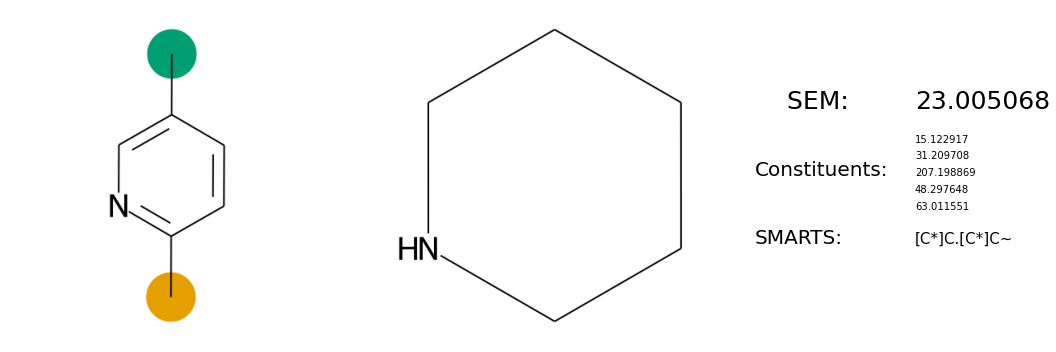

__________________________________________________________________________________________________________
mobley_1036761~mobley_1189457
./QUINTUP/30_dir_dir/finished/job_xax/sim_14/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_13/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_12/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_15/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_11/mobley_1036761~mobley_1189457/free


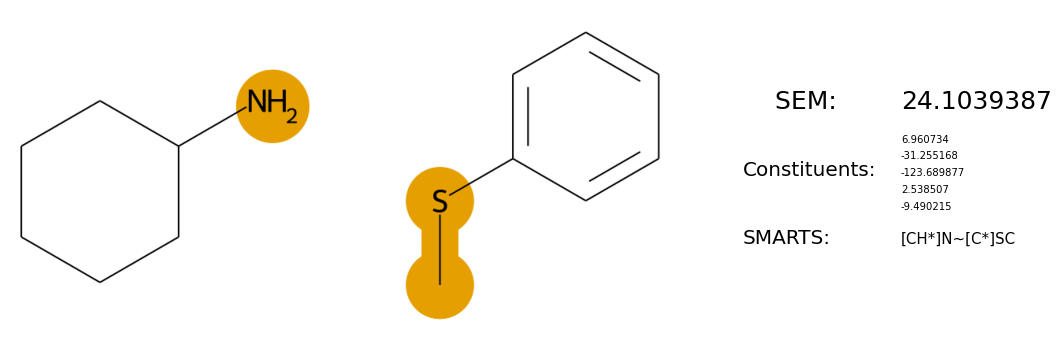

__________________________________________________________________________________________________________
mobley_1571523~mobley_2763835
./QUINTUP/30_dir_dir/finished/job_xgw/sim_3/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_1/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_5/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_4/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_2/mobley_1571523~mobley_2763835/free


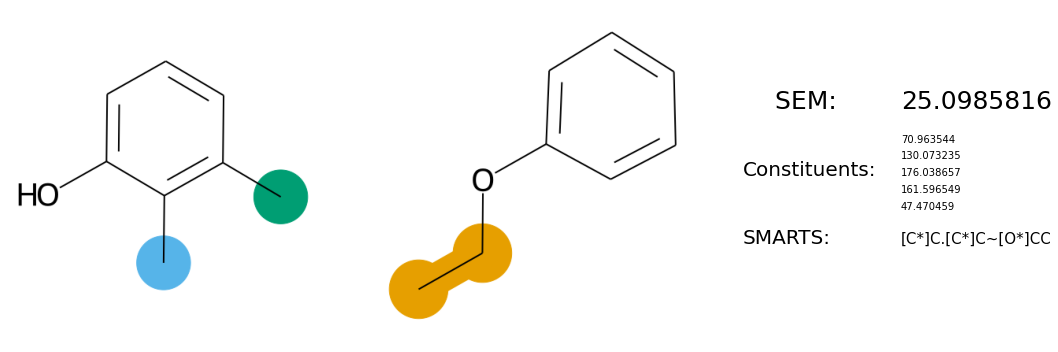

__________________________________________________________________________________________________________
mobley_1036761~mobley_4218209
./QUINTUP/30_dir_dir/finished/job_xbb/sim_3/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_1/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_5/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_4/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_2/mobley_1036761~mobley_4218209/free


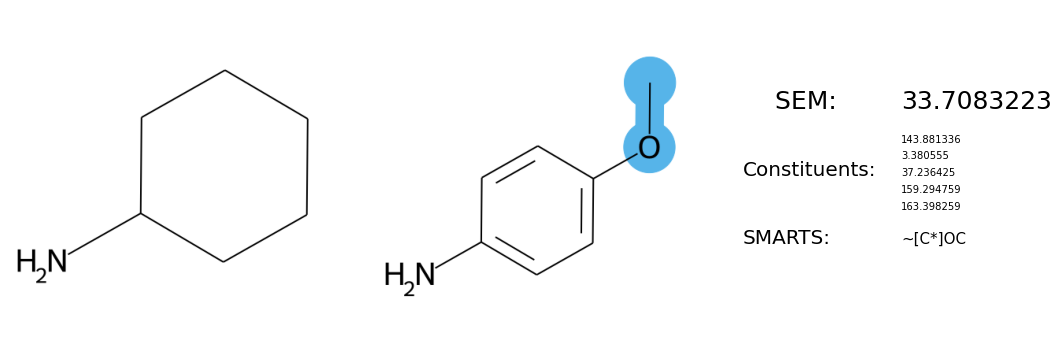

__________________________________________________________________________________________________________
mobley_1036761~mobley_2859600
./QUINTUP/30_dir_dir/finished/job_xaz/sim_14/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_13/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_12/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_15/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_11/mobley_1036761~mobley_2859600/free


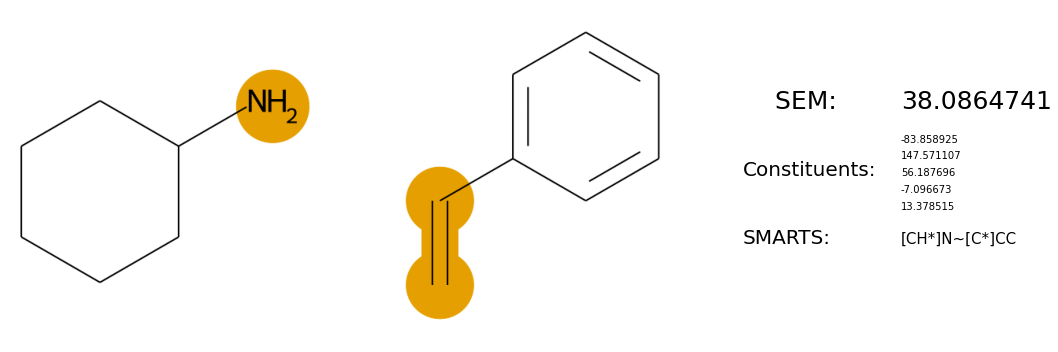

__________________________________________________________________________________________________________


In [12]:
%matplotlib inline
plot_perts(quints_infos.sort_values(by="sem").tail(10))

In [14]:
plot_perts(quints_infos[quints_infos["sem"] == 0.0].tail(10), precision=6)
# this cell doesn't return any values now that globbing is fixed.

# Lowest realistic SEMs:

mobley_1563176~mobley_2802855
./QUINTUP/29_dir_dir/finished/job_xcq/sim_14/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_13/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_12/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_15/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_11/mobley_1563176~mobley_2802855/free


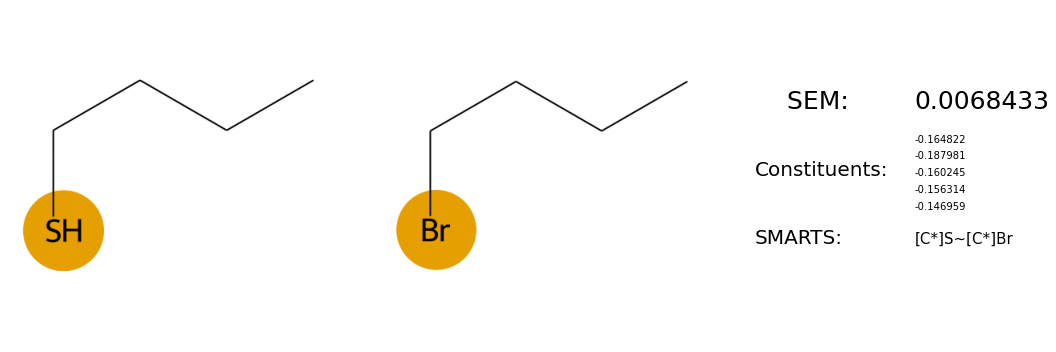

__________________________________________________________________________________________________________
mobley_186894~mobley_7708038
./QUINTUP/29_dir_dir/finished/job_xft/sim_3/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_1/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_5/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_4/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_2/mobley_186894~mobley_7708038/free


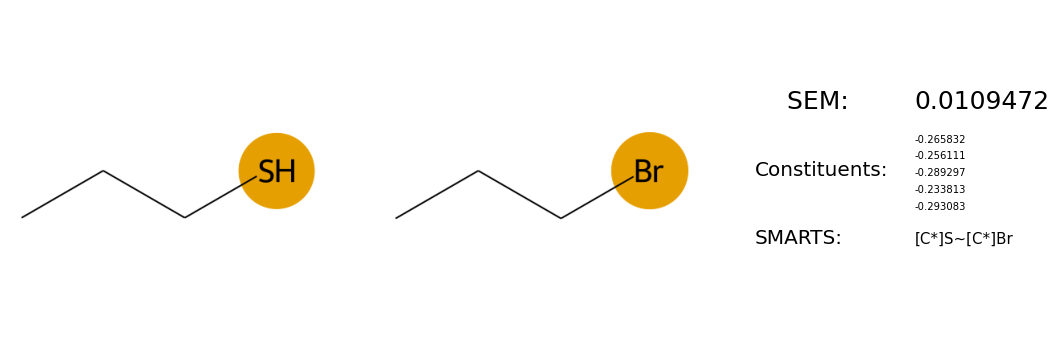

__________________________________________________________________________________________________________
mobley_1017962~mobley_7977115
./QUINTUP/24_dir_dir/round2/sim_194/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_191/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_192/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_193/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_195/mobley_1017962~mobley_7977115/free


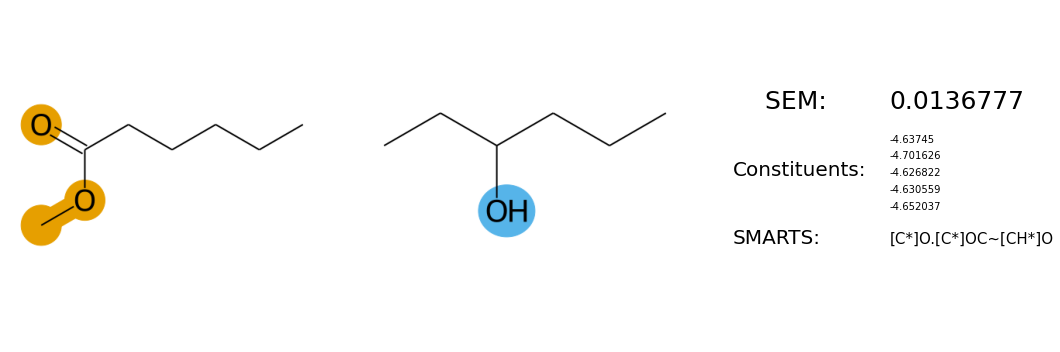

__________________________________________________________________________________________________________
mobley_1019269~mobley_9733743
./QUINTUP/29_dir_dir/finished/job_xaj/sim_18/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_20/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_17/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_19/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_16/mobley_1019269~mobley_9733743/free


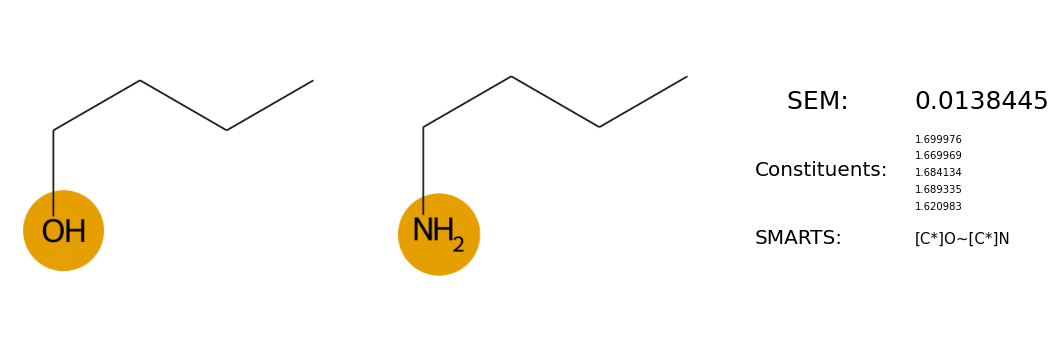

__________________________________________________________________________________________________________
mobley_1662128~mobley_6911232
./QUINTUP/30_dir_dir/finished/job_xig/sim_3/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_1/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_5/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_4/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_2/mobley_1662128~mobley_6911232/free


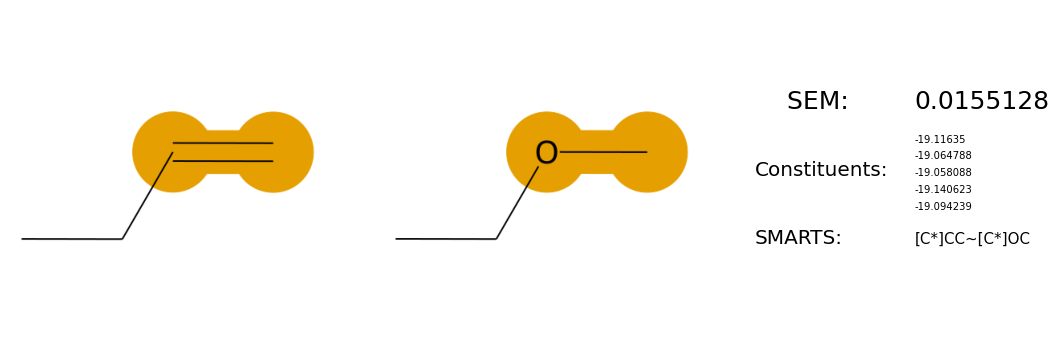

__________________________________________________________________________________________________________


In [15]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sort_values(by="sem").head(10))

# Randomly picked realistic SEMs:

mobley_3370989~mobley_1144156
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_0/mobley_3370989~mobley_1144156/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_3/mobley_3370989~mobley_1144156/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_1/mobley_3370989~mobley_1144156/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_2/mobley_3370989~mobley_1144156/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_1/mobley_3370989~mobley_1144156/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_0/mobley_3370989~mobley_1144156/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_3/mobley_3370989~mobley_1144156/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_1/mobley_3370989~mobley_1144156/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_1/GPU_population_2/mobley_3370989~mobley_1144156/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job

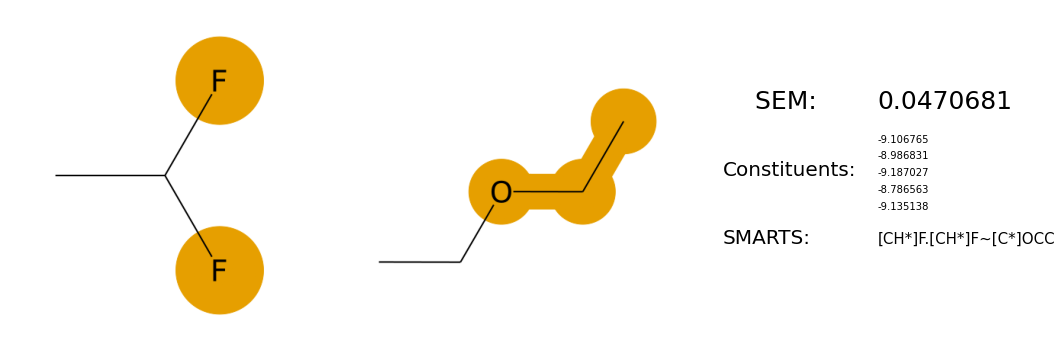

__________________________________________________________________________________________________________
mobley_1899443~mobley_8436428
./QUINTUP/29_dir_dir/finished/job_xhd/sim_14/mobley_1899443~mobley_8436428/free
./QUINTUP/29_dir_dir/finished/job_xhd/sim_13/mobley_1899443~mobley_8436428/free
./QUINTUP/29_dir_dir/finished/job_xhd/sim_12/mobley_1899443~mobley_8436428/free
./QUINTUP/29_dir_dir/finished/job_xhd/sim_15/mobley_1899443~mobley_8436428/free
./QUINTUP/29_dir_dir/finished/job_xhd/sim_11/mobley_1899443~mobley_8436428/free


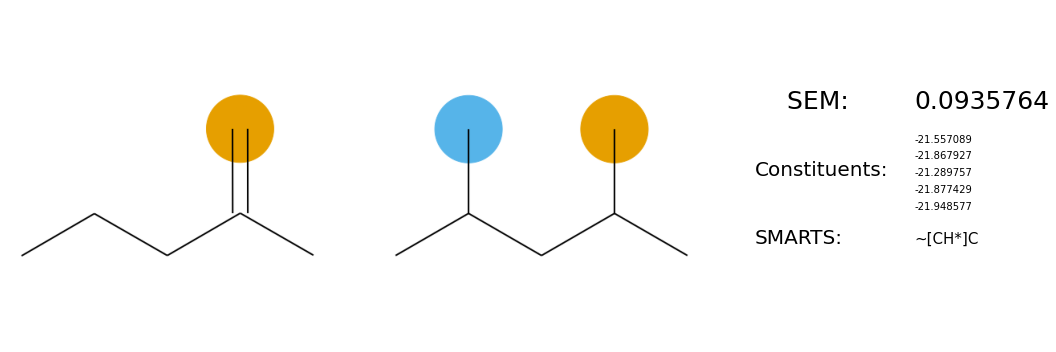

__________________________________________________________________________________________________________
mobley_1017962~mobley_1923244
./QUINTUP/26_dir_dir/round2/sim_37/mobley_1017962~mobley_1923244/free
./QUINTUP/26_dir_dir/round2/sim_39/mobley_1017962~mobley_1923244/free
./QUINTUP/26_dir_dir/round2/sim_40/mobley_1017962~mobley_1923244/free
./QUINTUP/26_dir_dir/round2/sim_38/mobley_1017962~mobley_1923244/free
./QUINTUP/26_dir_dir/round2/sim_36/mobley_1017962~mobley_1923244/free


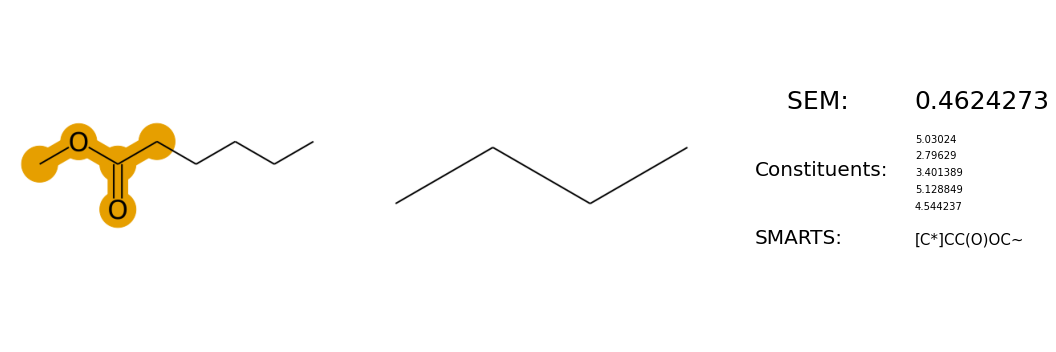

__________________________________________________________________________________________________________
mobley_9626434~mobley_5880265
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_14/mobley_9626434~mobley_5880265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_13/mobley_9626434~mobley_5880265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_12/mobley_9626434~mobley_5880265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_15/mobley_9626434~mobley_5880265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_11/mobley_9626434~mobley_5880265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_14/mobley_9626434~mobley_5880265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_13/mobley_9626434~mobley_5880265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyb/sim_12/mobley_9626434~mobley_5880265/free

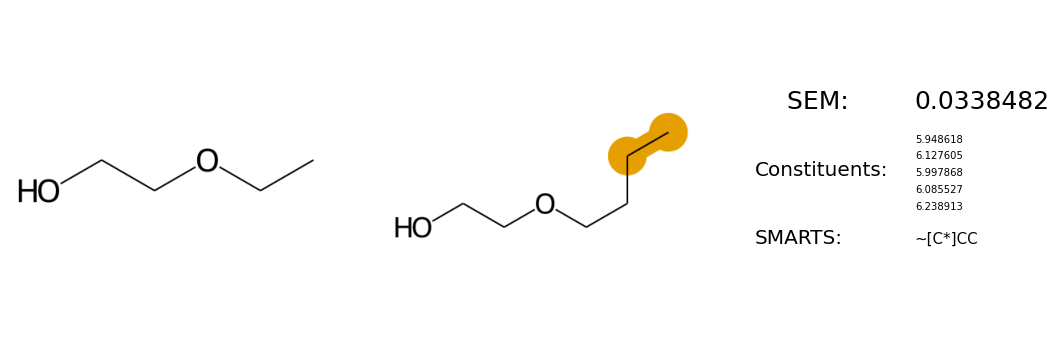

__________________________________________________________________________________________________________
mobley_1967551~mobley_1636752
./QUINTUP/29_dir_dir/finished/job_xib/sim_14/mobley_1967551~mobley_1636752/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_13/mobley_1967551~mobley_1636752/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_12/mobley_1967551~mobley_1636752/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_15/mobley_1967551~mobley_1636752/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_11/mobley_1967551~mobley_1636752/free


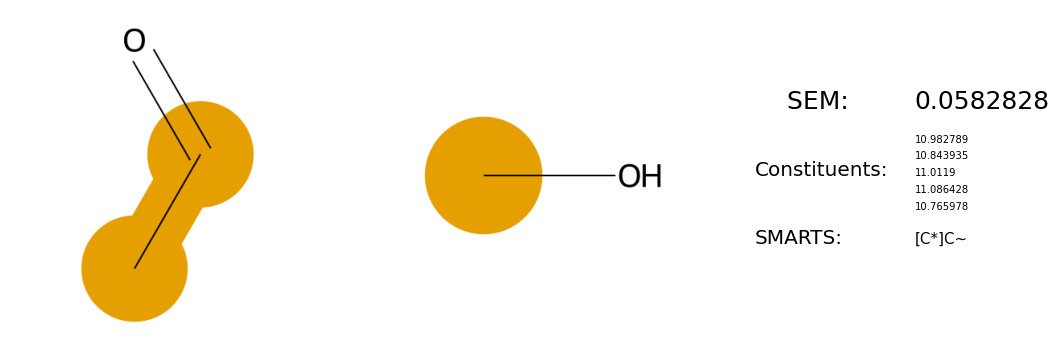

__________________________________________________________________________________________________________
mobley_186894~mobley_1563176
./QUINTUP/29_dir_dir/finished/job_xfr/sim_3/mobley_186894~mobley_1563176/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_3/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_1/mobley_186894~mobley_1563176/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_1/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_5/mobley_186894~mobley_1563176/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_5/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_4/mobley_186894~mobley_1563176/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_4/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_2/mobley_186894~mobley_1563176/mobley_186894~mobley_1563176/free
./QUINTUP/29_dir_

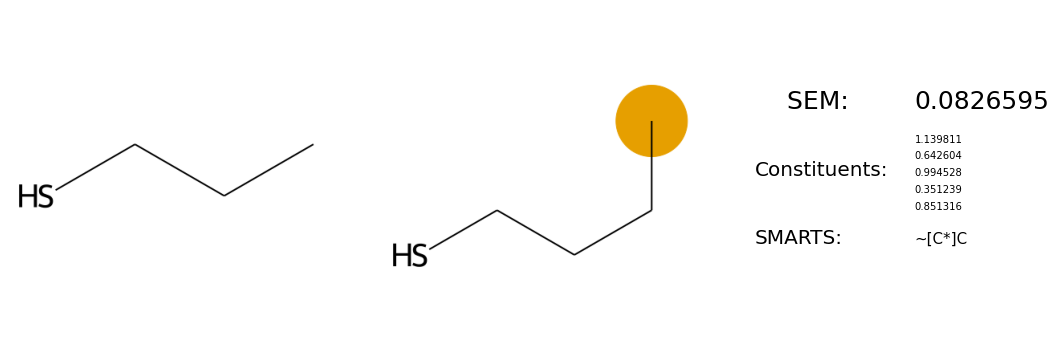

__________________________________________________________________________________________________________
mobley_1502181~mobley_9197172
./QUINTUP/30_dir_dir/finished/job_xfz/sim_18/mobley_1502181~mobley_9197172/free
./QUINTUP/30_dir_dir/finished/job_xfz/sim_20/mobley_1502181~mobley_9197172/free
./QUINTUP/30_dir_dir/finished/job_xfz/sim_17/mobley_1502181~mobley_9197172/free
./QUINTUP/30_dir_dir/finished/job_xfz/sim_19/mobley_1502181~mobley_9197172/free
./QUINTUP/30_dir_dir/finished/job_xfz/sim_16/mobley_1502181~mobley_9197172/free


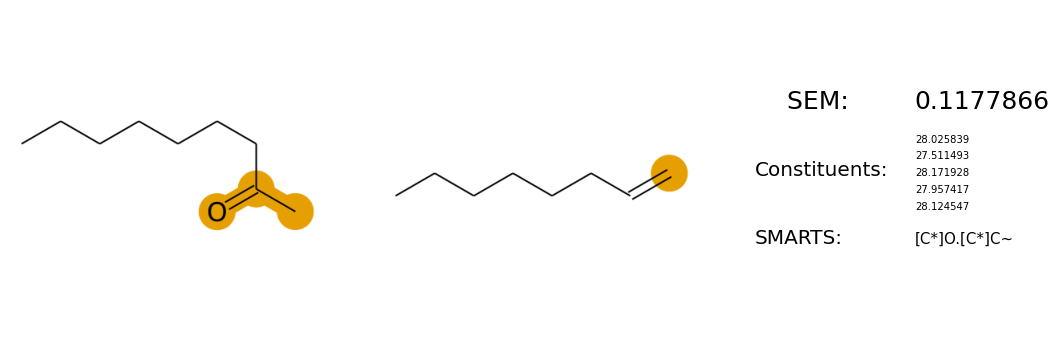

__________________________________________________________________________________________________________
mobley_1615431~mobley_6854178
./QUINTUP/30_dir_dir/finished/job_xhh/sim_14/mobley_1615431~mobley_6854178/free
./QUINTUP/30_dir_dir/finished/job_xhh/sim_13/mobley_1615431~mobley_6854178/free
./QUINTUP/30_dir_dir/finished/job_xhh/sim_12/mobley_1615431~mobley_6854178/free
./QUINTUP/30_dir_dir/finished/job_xhh/sim_15/mobley_1615431~mobley_6854178/free
./QUINTUP/30_dir_dir/finished/job_xhh/sim_11/mobley_1615431~mobley_6854178/free


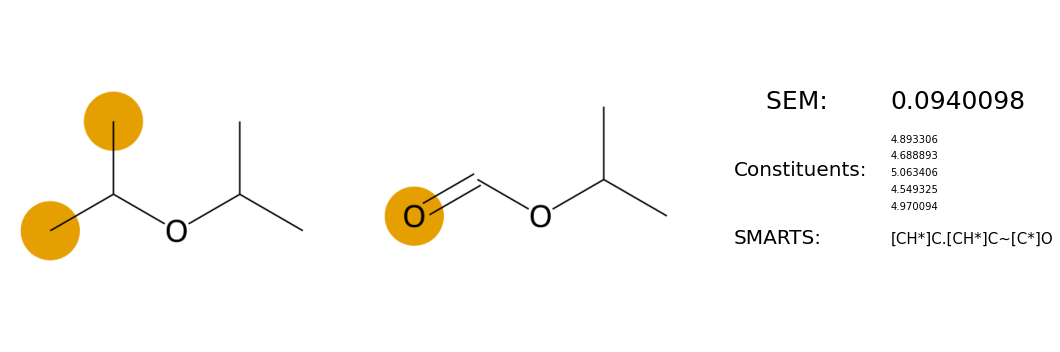

__________________________________________________________________________________________________________
mobley_929676~mobley_6896128
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_18/mobley_929676~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_20/mobley_929676~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_17/mobley_929676~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_19/mobley_929676~mobley_6896128/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_16/mobley_929676~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_18/mobley_929676~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_20/mobley_929676~mobley_6896128/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvq/sim_17/mobley_929676~mobley_6896128/free
./MGZ_RE

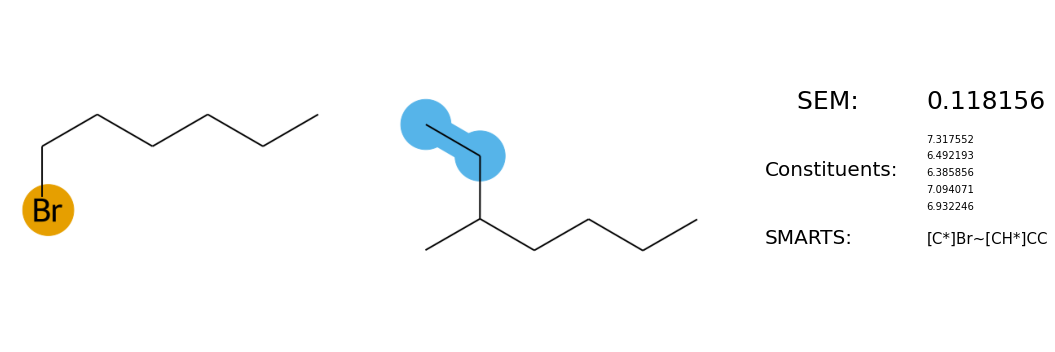

__________________________________________________________________________________________________________
mobley_9883303~mobley_5759258
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeal/mobley_9883303~mobley_5759258/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_18/mobley_9883303~mobley_5759258/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_17/mobley_9883303~mobley_5759258/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_19/mobley_9883303~mobley_5759258/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_16/mobley_9883303~mobley_5759258/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeal/mobley_9883303~mobley_5759258/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_18/mobley_9883303~mobley_5759258/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeal/sim_17/mobley_9883303~mobley_5759258/free
./MGZ_RECENT/

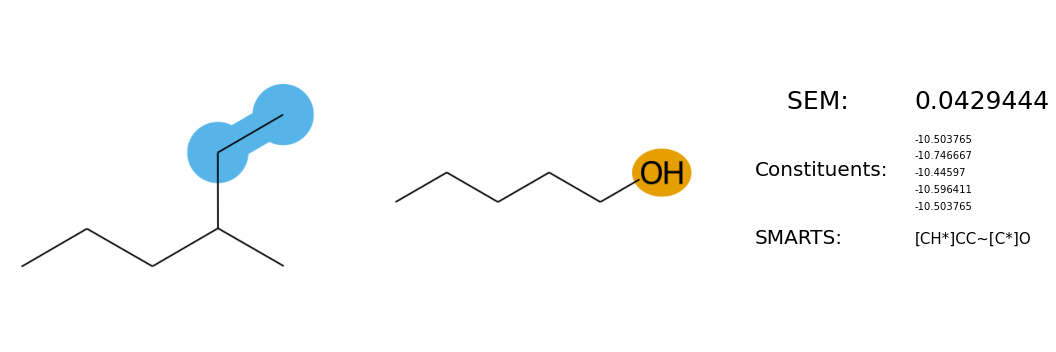

__________________________________________________________________________________________________________
mobley_1636752~mobley_8983100
./QUINTUP/30_dir_dir/finished/job_xhk/sim_7/mobley_1636752~mobley_8983100/free
./QUINTUP/30_dir_dir/finished/job_xhk/sim_9/mobley_1636752~mobley_8983100/free
./QUINTUP/30_dir_dir/finished/job_xhk/sim_8/mobley_1636752~mobley_8983100/free
./QUINTUP/30_dir_dir/finished/job_xhk/sim_6/mobley_1636752~mobley_8983100/free
./QUINTUP/30_dir_dir/finished/job_xhk/sim_10/mobley_1636752~mobley_8983100/free


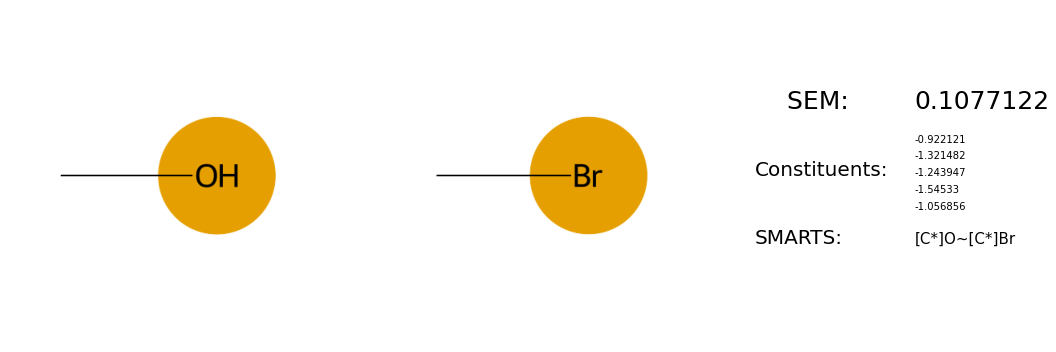

__________________________________________________________________________________________________________
mobley_1107178~mobley_2068538
./QUINTUP/29_dir_dir/finished/job_xax/sim_3/mobley_1107178~mobley_2068538/free
./QUINTUP/29_dir_dir/finished/job_xax/sim_1/mobley_1107178~mobley_2068538/free
./QUINTUP/29_dir_dir/finished/job_xax/sim_5/mobley_1107178~mobley_2068538/free
./QUINTUP/29_dir_dir/finished/job_xax/sim_4/mobley_1107178~mobley_2068538/free
./QUINTUP/29_dir_dir/finished/job_xax/sim_2/mobley_1107178~mobley_2068538/free


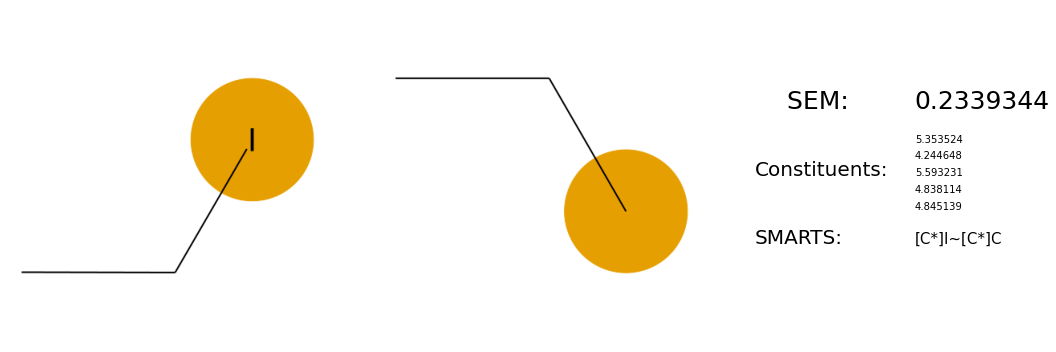

__________________________________________________________________________________________________________
mobley_1017962~mobley_1662128
./QUINTUP/26_dir_dir/round2/sim_18/mobley_1017962~mobley_1662128/free
./QUINTUP/26_dir_dir/round2/sim_20/mobley_1017962~mobley_1662128/free
./QUINTUP/26_dir_dir/round2/sim_17/mobley_1017962~mobley_1662128/free
./QUINTUP/26_dir_dir/round2/sim_19/mobley_1017962~mobley_1662128/free
./QUINTUP/26_dir_dir/round2/sim_16/mobley_1017962~mobley_1662128/free


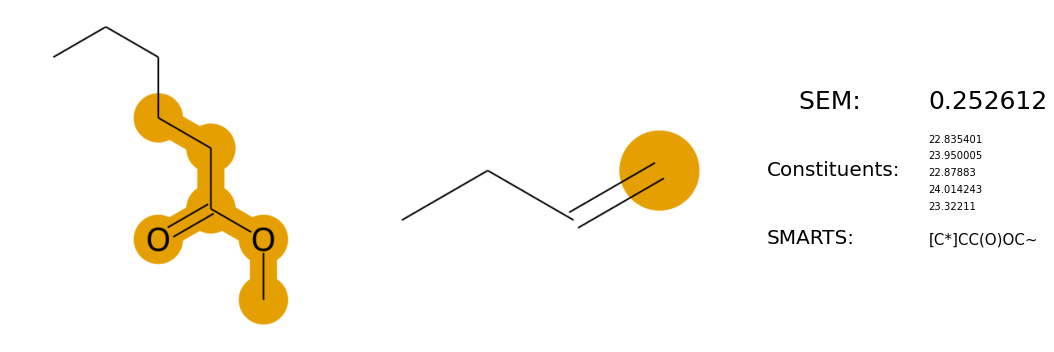

__________________________________________________________________________________________________________
mobley_9434451~mobley_1650157
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_7/mobley_9434451~mobley_1650157/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_9/mobley_9434451~mobley_1650157/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_8/mobley_9434451~mobley_1650157/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_6/mobley_9434451~mobley_1650157/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_10/mobley_9434451~mobley_1650157/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_7/mobley_9434451~mobley_1650157/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_9/mobley_9434451~mobley_1650157/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwc/sim_8/mobley_9434451~mobley_1650157/free
./MGZ_

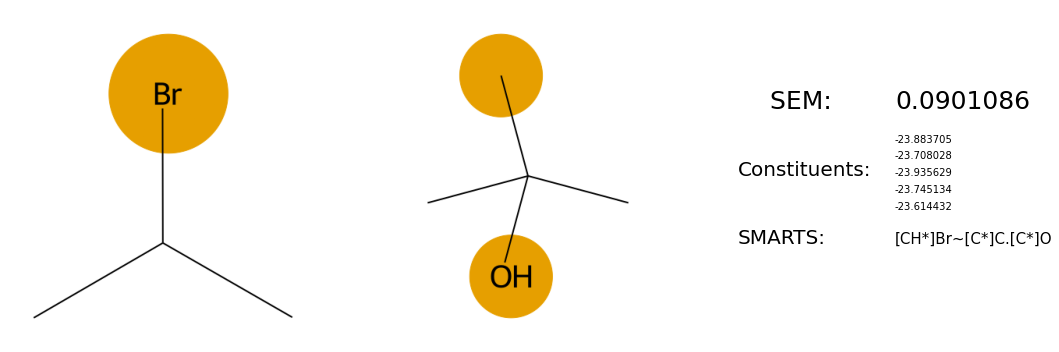

__________________________________________________________________________________________________________
mobley_1875719~mobley_2213823
./QUINTUP/29_dir_dir/finished/job_xgc/sim_3/mobley_1875719~mobley_2213823/free
./QUINTUP/29_dir_dir/finished/job_xgc/sim_1/mobley_1875719~mobley_2213823/free
./QUINTUP/29_dir_dir/finished/job_xgc/sim_5/mobley_1875719~mobley_2213823/free
./QUINTUP/29_dir_dir/finished/job_xgc/sim_4/mobley_1875719~mobley_2213823/free
./QUINTUP/29_dir_dir/finished/job_xgc/sim_2/mobley_1875719~mobley_2213823/free


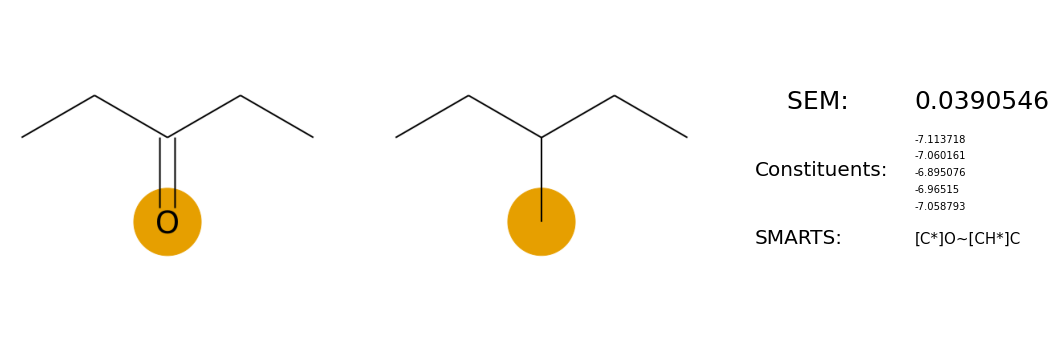

__________________________________________________________________________________________________________
mobley_1571523~mobley_4035953
./QUINTUP/29_dir_dir/finished/job_xcx/sim_3/mobley_1571523~mobley_4035953/free
./QUINTUP/29_dir_dir/finished/job_xcx/sim_1/mobley_1571523~mobley_4035953/free
./QUINTUP/29_dir_dir/finished/job_xcx/sim_5/mobley_1571523~mobley_4035953/free
./QUINTUP/29_dir_dir/finished/job_xcx/sim_4/mobley_1571523~mobley_4035953/free
./QUINTUP/29_dir_dir/finished/job_xcx/sim_2/mobley_1571523~mobley_4035953/free


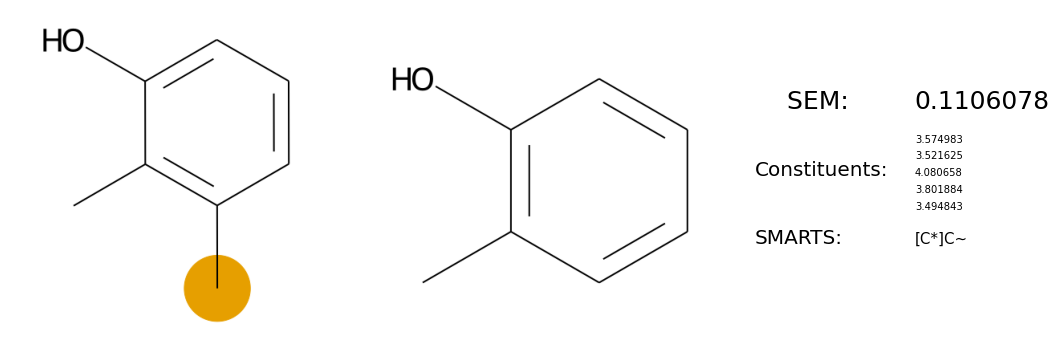

__________________________________________________________________________________________________________
mobley_1502181~mobley_3378420
./QUINTUP/29_dir_dir/finished/job_xck/sim_3/mobley_1502181~mobley_3378420/free
./QUINTUP/29_dir_dir/finished/job_xck/sim_1/mobley_1502181~mobley_3378420/free
./QUINTUP/29_dir_dir/finished/job_xck/sim_5/mobley_1502181~mobley_3378420/free
./QUINTUP/29_dir_dir/finished/job_xck/sim_4/mobley_1502181~mobley_3378420/free
./QUINTUP/29_dir_dir/finished/job_xck/sim_2/mobley_1502181~mobley_3378420/free


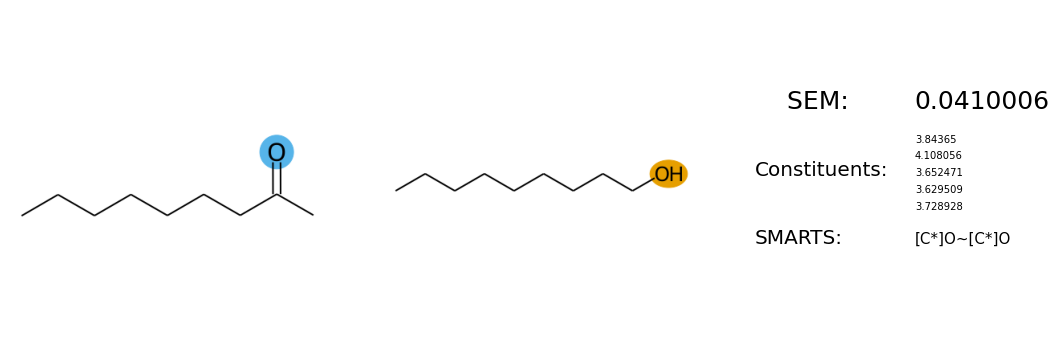

__________________________________________________________________________________________________________
mobley_1019269~mobley_2008055
./QUINTUP/24_dir_dir/round2/sim_297/mobley_1019269~mobley_2008055/free
./QUINTUP/24_dir_dir/round2/sim_296/mobley_1019269~mobley_2008055/free
./QUINTUP/24_dir_dir/round2/sim_299/mobley_1019269~mobley_2008055/free
./QUINTUP/24_dir_dir/round2/sim_300/mobley_1019269~mobley_2008055/free
./QUINTUP/24_dir_dir/round2/sim_298/mobley_1019269~mobley_2008055/free


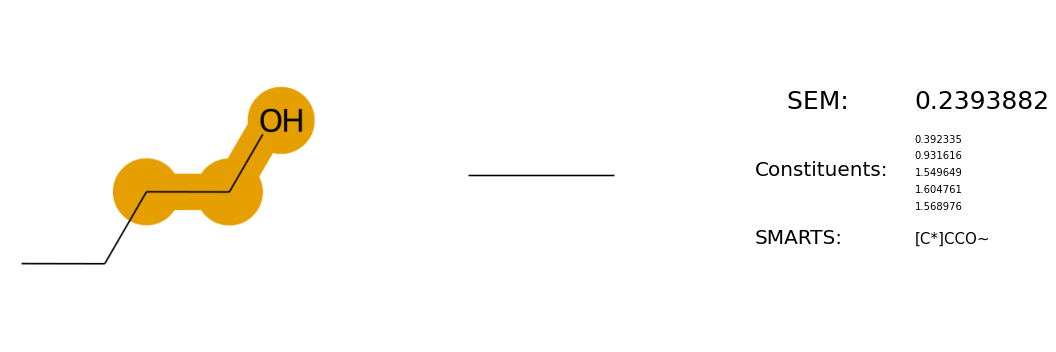

__________________________________________________________________________________________________________
mobley_1967551~mobley_6091882
./QUINTUP/29_dir_dir/finished/job_xie/sim_7/mobley_1967551~mobley_6091882/free
./QUINTUP/29_dir_dir/finished/job_xie/sim_9/mobley_1967551~mobley_6091882/free
./QUINTUP/29_dir_dir/finished/job_xie/sim_8/mobley_1967551~mobley_6091882/free
./QUINTUP/29_dir_dir/finished/job_xie/sim_6/mobley_1967551~mobley_6091882/free
./QUINTUP/29_dir_dir/finished/job_xie/sim_10/mobley_1967551~mobley_6091882/free


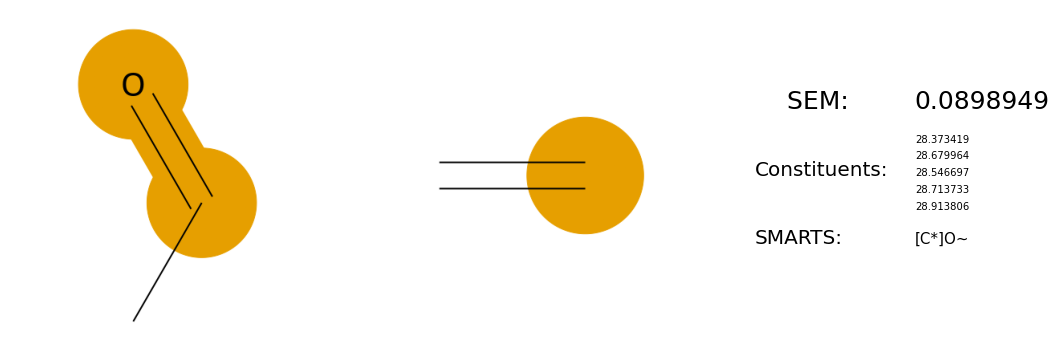

__________________________________________________________________________________________________________
mobley_994483~mobley_2802855
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_3/mobley_994483~mobley_2802855/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_1/mobley_994483~mobley_2802855/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_5/mobley_994483~mobley_2802855/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_4/mobley_994483~mobley_2802855/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_2/mobley_994483~mobley_2802855/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_3/mobley_994483~mobley_2802855/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_1/mobley_994483~mobley_2802855/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebq/sim_5/mobley_994483~mobley_2802855/free
./MGZ_RECENT/02_

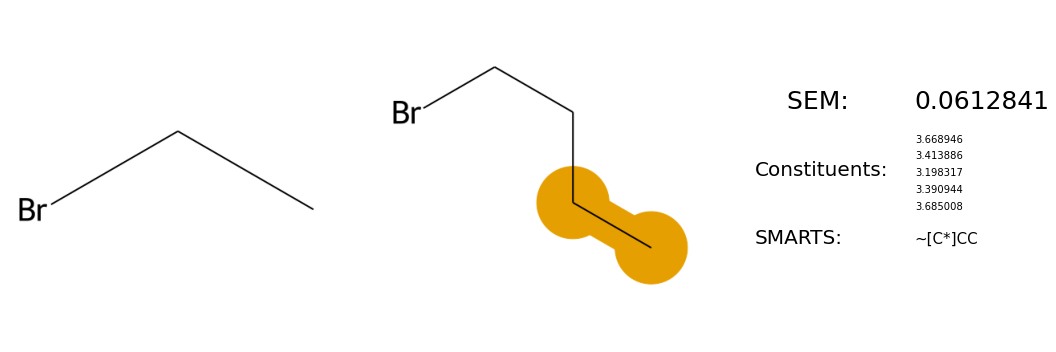

__________________________________________________________________________________________________________
mobley_1717215~mobley_7326982
./QUINTUP/30_dir_dir/finished/job_xjc/sim_14/mobley_1717215~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xjc/sim_13/mobley_1717215~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xjc/sim_12/mobley_1717215~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xjc/sim_15/mobley_1717215~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xjc/sim_11/mobley_1717215~mobley_7326982/free


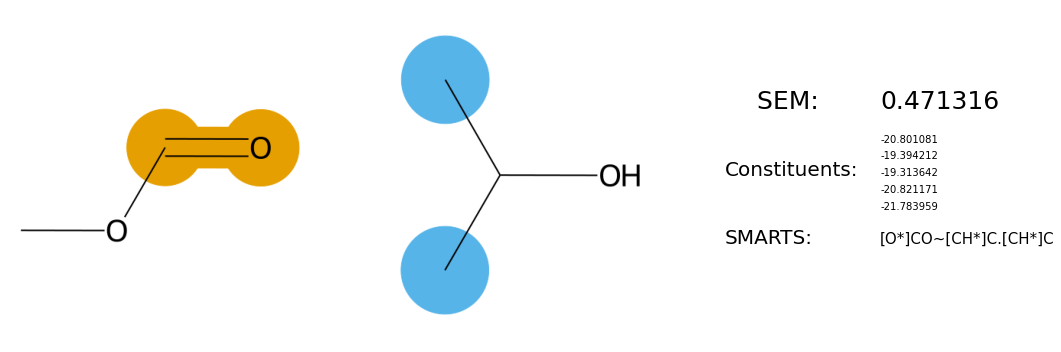

__________________________________________________________________________________________________________
mobley_1019269~mobley_4924862
./QUINTUP/24_dir_dir/round2/sim_409/mobley_1019269~mobley_4924862/free
./QUINTUP/24_dir_dir/round2/sim_408/mobley_1019269~mobley_4924862/free
./QUINTUP/24_dir_dir/round2/sim_410/mobley_1019269~mobley_4924862/free
./QUINTUP/24_dir_dir/round2/sim_407/mobley_1019269~mobley_4924862/free
./QUINTUP/24_dir_dir/round2/sim_406/mobley_1019269~mobley_4924862/free


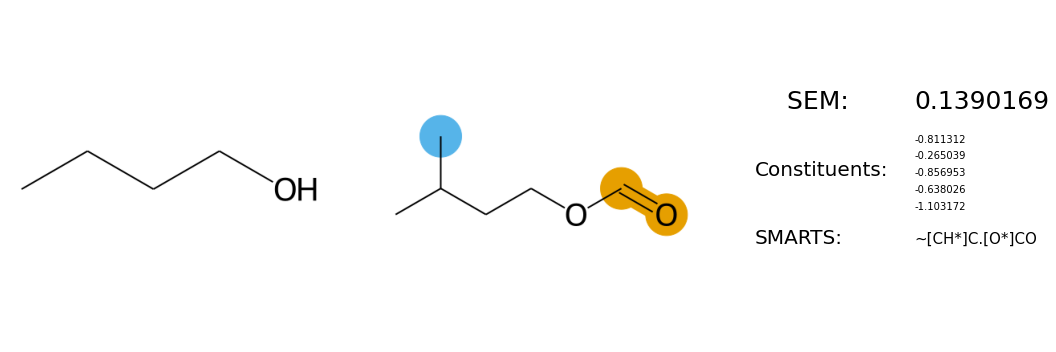

__________________________________________________________________________________________________________
mobley_20524~mobley_7295828
./QUINTUP/29_dir_dir/finished/job_xjf/sim_7/mobley_20524~mobley_7295828/free
./QUINTUP/29_dir_dir/finished/job_xjf/sim_9/mobley_20524~mobley_7295828/free
./QUINTUP/29_dir_dir/finished/job_xjf/sim_8/mobley_20524~mobley_7295828/free
./QUINTUP/29_dir_dir/finished/job_xjf/sim_6/mobley_20524~mobley_7295828/free
./QUINTUP/29_dir_dir/finished/job_xjf/sim_10/mobley_20524~mobley_7295828/free


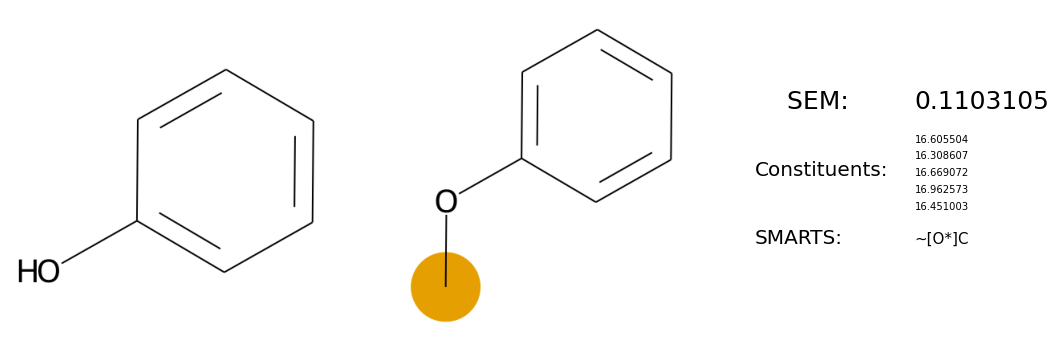

__________________________________________________________________________________________________________
mobley_1017962~mobley_9407874
./QUINTUP/30_dir_dir/finished/job_xae/sim_7/mobley_1017962~mobley_9407874/free
./QUINTUP/30_dir_dir/finished/job_xae/sim_9/mobley_1017962~mobley_9407874/free
./QUINTUP/30_dir_dir/finished/job_xae/sim_8/mobley_1017962~mobley_9407874/free
./QUINTUP/30_dir_dir/finished/job_xae/sim_6/mobley_1017962~mobley_9407874/free
./QUINTUP/30_dir_dir/finished/job_xae/sim_10/mobley_1017962~mobley_9407874/free


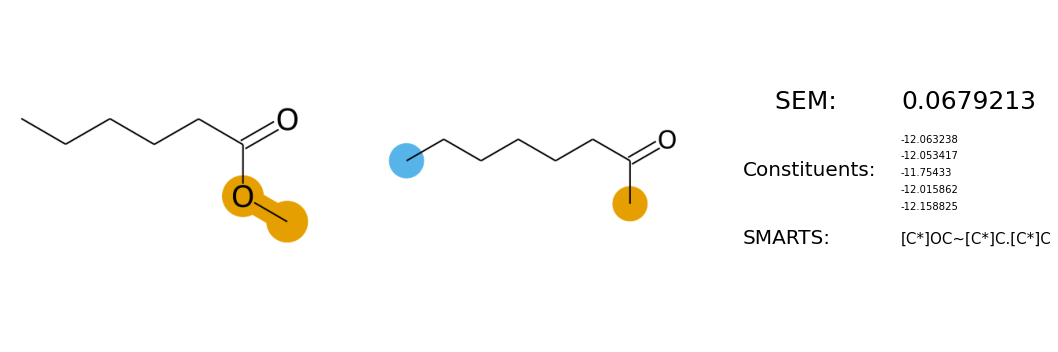

__________________________________________________________________________________________________________


In [16]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sample(50))